# Imports

In [ ]:
pip install neurokit2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 4.4 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
import warnings
import scipy as sp
import gc
import statistics
import random
import warnings
import neurokit2 as nk
import seaborn as sns

# Load the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_name = "/content/drive/MyDrive/X_final.npy"
X = np.load(file_name)

In [ ]:
X.shape

(148754, 2, 1000)

In [ ]:
file_name = "/content/drive/MyDrive/y_final.npy"
y = np.load(file_name)

In [ ]:
y.shape

(148754,)

In [ ]:
X

array([[[0.31016988, 0.2976684 , 0.28525799, ..., 0.34793372,
         0.35132553, 0.35525337],
        [0.07208444, 0.06345778, 0.06681584, ..., 0.31806872,
         0.33382037, 0.3521739 ]],

       [[0.45419039, 0.43005155, 0.40914425, ..., 0.51737679,
         0.47216384, 0.42575017],
        [0.35116199, 0.32190212, 0.28431279, ..., 0.19530947,
         0.19537867, 0.19423687]],

       [[0.38472693, 0.34626   , 0.30894344, ..., 0.39438954,
         0.39844598, 0.40311328],
        [0.1833402 , 0.17345746, 0.16003046, ..., 0.3333287 ,
         0.34846313, 0.36345773]],

       ...,

       [[0.30416684, 0.30197704, 0.29954343, ..., 0.30285289,
         0.30410655, 0.30538371],
        [0.51166676, 0.52581182, 0.55066952, ..., 0.59431768,
         0.55765217, 0.5172042 ]],

       [[0.5044252 , 0.50363875, 0.50248212, ..., 0.37410082,
         0.37352523, 0.37297001],
        [0.4179762 , 0.40676082, 0.4010545 , ..., 0.36548891,
         0.36375489, 0.36355641]],

       [[0.445849

# Visualizations

In [ ]:
sns.set()

## PPG

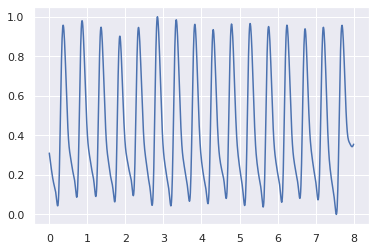

In [ ]:
plt.plot(np.linspace(0., 8, 1000), X[0][0])

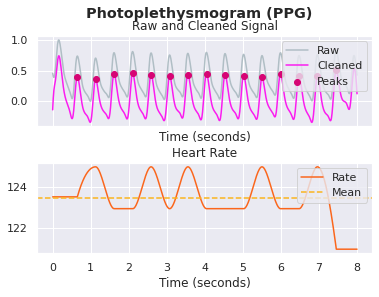

In [ ]:
ppg = X[1][0]
ppg_signal, info = nk.ppg_process(ppg, sampling_rate=125)
plot = nk.ppg_plot(ppg_signal, sampling_rate=125)

## ECG

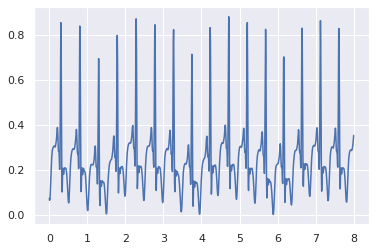

In [ ]:
plt.plot(np.linspace(0., 8, 1000), X[0][1])

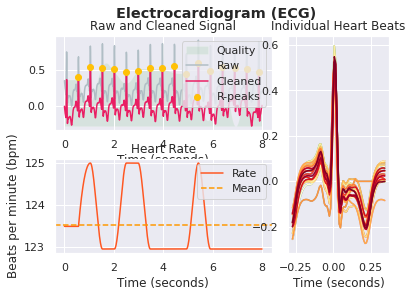

In [ ]:
ecg = X[1][1]
ecg_signal, info = nk.ecg_process(ecg, sampling_rate=125)
plot = nk.ecg_plot(ecg_signal, sampling_rate=125)

# Class Imbalance

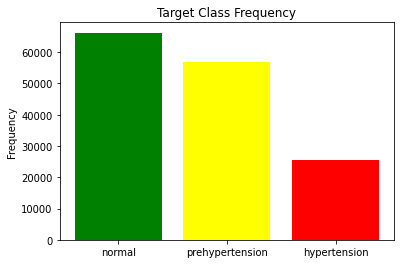

In [ ]:
normal = np.count_nonzero(y == 0)
prehypertension = np.count_nonzero(y == 1)
hypertension = np.count_nonzero(y == 2)
total = normal + prehypertension + hypertension

plt.bar(["normal", "prehypertension", "hypertension"], [normal, prehypertension, hypertension], color=["green", "yellow", "red"]);
plt.title("Target Class Frequency");
plt.ylabel("Frequency")
plt.xticks(rotation=0);

In [ ]:
# assigning class weights
weight_for_0 = (1 / normal) * (total / 3.0)
weight_for_1 = (1 / prehypertension) * (total / 3.0)
weight_for_2 = (1 / hypertension) * (total / 3.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

Weight for class 0: 0.75
Weight for class 1: 0.87
Weight for class 2: 1.93


# Models


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, BatchNormalization, Flatten, Bidirectional, TimeDistributed, Activation, Conv2D, MaxPooling2D, CuDNNLSTM
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import imblearn

In [ ]:
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

  #creating a set of all the unique classes using the actual class list
  unique_class = set(actual_class)
  roc_auc_dict = {}
  for per_class in unique_class:
    #creating a list of all the classes except the current class 
    other_class = [x for x in unique_class if x != per_class]

    #marking the current class as 1 and all other classes as 0
    new_actual_class = [0 if x in other_class else 1 for x in actual_class]
    new_pred_class = [0 if x in other_class else 1 for x in pred_class]

    #using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
    roc_auc_dict[per_class] = roc_auc

  return roc_auc_dict

In [ ]:
def evaluate_model(model, X_test, y_test):
  score = model.evaluate(X_test, y_test, verbose=0)
  print('Test loss:', round(score[0], 5))
  print('Test accuracy:', round(score[1], 5))

  # classification report
  y_pred = model.predict(X_test)
  y_pred = tf.argmax(y_pred,axis=1)
  report_dictionary = classification_report(y_test, y_pred, output_dict = True)
  print(classification_report(y_test, y_pred, output_dict=False))

  cm = 1/2.54
  fig, axs = plt.subplots(1, 1, figsize=(17*cm, 15*cm))

  x_axis_labels = ["Normal", "Prehypertension", "Hypertension"] # labels for x-axis
  y_axis_labels = ["Normal", "Prehypertension", "Hypertension"] # labels for y-axis

  sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=True, fmt='g', 
            cmap=plt.cm.Blues, ax=axs, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
  axs.set_xlabel ("Predicted labels")
  axs.set_ylabel ("True labels")
  plt.show()

  # AUCROC
  lr_roc_auc_multiclass = roc_auc_score_multiclass(y_test, y_pred)
  print(lr_roc_auc_multiclass)

In [ ]:
def summarize_diagnostics(history):
	sns.reset_orig()
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='validation')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	# plt.legend()
	# plt.show()

	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	plt.xlabel('Epochs')
	plt.ylabel('Accuracy')


In [ ]:
#original model
def define_model(input_shape):
  n_seq, n_steps, n_features = input_shape[0], input_shape[1], input_shape[2]
  model = Sequential()
  model.add(TimeDistributed(Conv1D(filters=100, kernel_size=5, activation='relu'), input_shape=(n_seq, n_steps, n_features)))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(BatchNormalization())
  model.add(Bidirectional(LSTM(128, return_sequences=True)))
  model.add(Dropout(0.2))
  model.add(Bidirectional(LSTM(128, return_sequences=False)))
  model.add(Dropout(0.2))
  model.add(Dense(128))
  model.add(Dense(3, activation='softmax'))
  print(model.summary())
  

  opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

  # Compile model
  model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer=opt,
      metrics=['accuracy'])
  
  return model

In [ ]:
#CNN
def define_model2(input_shape):
  n_seq, n_steps, n_features = input_shape[0], input_shape[1], input_shape[2]
  model = Sequential()
  model.add(Conv2D(128, (3,3), input_shape=input_shape))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(128, (3,3)))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Flatten())
  model.add(Dropout(0.2))
  model.add(Dense(128))
  model.add(Dense(3, activation="softmax"))
  print(model.summary())


  opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

  # Compile model
  model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer=opt,
      metrics=['accuracy'])

  return model

In [ ]:
#fully connected
def define_model3(input_shape):
  model=Sequential()
  model.add(Flatten(input_shape=input_shape))
  model.add(Dense(128, activation="relu"))
  model.add(Dense(64, activation="relu"))
  model.add(Dense(32))
  model.add(Dense(3, activation="softmax"))
  print(model.summary())


  opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

  # Compile model
  model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer=opt,
      metrics=['accuracy'])

  return model

In [ ]:
#LSTM
def define_model4(input_shape):
  model=Sequential()
  model.add(TimeDistributed(Conv1D(filters=100, kernel_size=5, activation='relu'), input_shape=input_shape))
  model.add(TimeDistributed(Flatten()))
  model.add(BatchNormalization())
  model.add(LSTM(128, batch_input_shape=input_shape, return_sequences=True))
  model.add(LSTM(128, return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(128))
  model.add(Dense(3, activation="softmax"))
  print(model.summary())


  opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

  # Compile model
  model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer=opt,
      metrics=['accuracy'])

  return model

In [ ]:
#CNN-LSTM
def define_model5(input_shape):
  model=Sequential()
  model.add(Conv2D(128, (3,3), input_shape=input_shape))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(128, (3,3)))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(128, return_sequences=True))
  model.add(LSTM(128, return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(128))
  model.add(Dense(3, activation="softmax"))
  print(model.summary())


  opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

  # Compile model
  model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer=opt,
      metrics=['accuracy'])

  return model

In [ ]:
#recurrent
def define_model6(input_shape):
  model=Sequential()
  model.add(TimeDistributed(Conv1D(filters=100, kernel_size=5, activation='relu'), input_shape=input_shape))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(BatchNormalization())
  model.add(CuDNNLSTM(128, input_shape=input_shape, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(CuDNNLSTM(128, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(CuDNNLSTM(128))
  model.add(Dropout(0.2))
  model.add(Dense(128, activation="relu"))
  model.add(Dropout(0.2))
  model.add(Dense(3, activation="softmax"))
  print(model.summary())


  opt = tf.keras.optimizers.Adam(learning_rate=0.0005, decay=1e-6)

  # Compile model
  model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer=opt,
      metrics=['accuracy'])

  return model


In [ ]:
ppg_signals = list()
ecg_signals = list()

for signal in X:
  ppg = signal[0]
  ecg = signal[1]
  ppg_signals.append(signal[0].reshape(100, 10, 1))
  ecg_signals.append(signal[1].reshape(100, 10, 1))

X = np.concatenate((ppg_signals, ecg_signals), axis=3)

del ppg_signals
del ecg_signals

X.shape

(148754, 100, 10, 2)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.15, random_state=42)

In [ ]:
# deleting variable from RAM 

del X
del y

gc.collect()

239

In [ ]:
X_train.shape[1:]

(100, 10, 2)

In [ ]:
model = define_model6(X_train.shape[1:])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 100, 6, 100)      1100      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 100, 3, 100)      0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 100, 300)         0         
 tributed)                                                       
                                                                 
 batch_normalization (BatchN  (None, 100, 300)         1200      
 ormalization)                                                   
                                                                 
 cu_dnnlstm (CuDNNLSTM)      (None, 100, 128)          2

In [ ]:
# Train model
BATCH_SIZE = 256
EPOCHS = 50

filepath = "./my_best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')


es = EarlyStopping(monitor='val_loss', mode='min', patience=3)

callbacks = [checkpoint, es]

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=class_weight,
    validation_data=(X_val, y_val),
    callbacks= callbacks
)

model = keras.models.load_model("./my_best_model.hdf5")

Epoch 1/50
494/494 [==============================] - ETA: 0s - loss: 0.4137 - accuracy: 0.8169
Epoch 1: val_loss improved from inf to 0.48631, saving model to ./my_best_model.hdf5
494/494 [==============================] - 41s 80ms/step - loss: 0.4137 - accuracy: 0.8169 - val_loss: 0.4863 - val_accuracy: 0.7894
Epoch 2/50
494/494 [==============================] - ETA: 0s - loss: 0.4020 - accuracy: 0.8210
Epoch 2: val_loss improved from 0.48631 to 0.48132, saving model to ./my_best_model.hdf5
494/494 [==============================] - 39s 80ms/step - loss: 0.4020 - accuracy: 0.8210 - val_loss: 0.4813 - val_accuracy: 0.7903
Epoch 3/50
494/494 [==============================] - ETA: 0s - loss: 0.3939 - accuracy: 0.8251
Epoch 3: val_loss improved from 0.48132 to 0.47556, saving model to ./my_best_model.hdf5
494/494 [==============================] - 39s 80ms/step - loss: 0.3939 - accuracy: 0.8251 - val_loss: 0.4756 - val_accuracy: 0.7960
Epoch 4/50
494/494 [==============================

Test loss: 0.44736
Test accuracy: 0.80908
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      8564
           1       0.77      0.75      0.76      7161
           2       0.70      0.86      0.77      3241

    accuracy                           0.81     18966
   macro avg       0.79      0.82      0.80     18966
weighted avg       0.81      0.81      0.81     18966



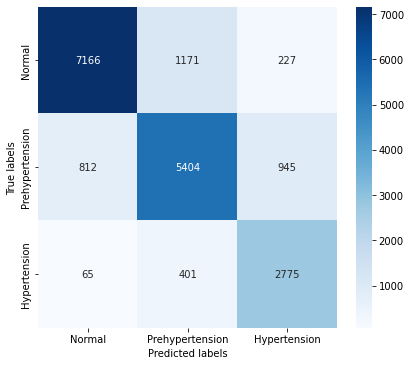

{0: 0.876223907287617, 1: 0.8107396463300878, 2: 0.8908431076592682}


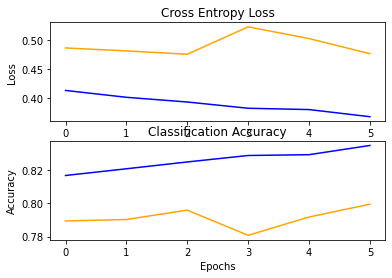

In [ ]:
# Evaluate model
evaluate_model(model, X_test, y_test)
summarize_diagnostics(history)